<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week9/TSLA_RNN_LSTM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# -------------------------------------
# 1. 데이터 로드 및 전처리
# -------------------------------------

# URL에서 TSLA CSV 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/TSLA.csv"
# 'Date' 컬럼을 파싱하고 인덱스로 설정
df = pd.read_csv(url, parse_dates=['Date'], index_col='Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


In [3]:
# Adj Close, Volume 드롭 (요청 사항)
df = df.drop(columns=['Adj Close', 'Volume'])

# 피처 (Open, High, Low, Close)와 타겟 (Close) 분리
features_raw = df.values.astype(float) # (N, 4)
target_raw = df['Close'].values.astype(float) # (N,)

In [4]:
# -------------------------------------
# 2. Train / Test 분리 및 스케일링
# -------------------------------------

# 8:2 비율로 분리
split_ratio = 0.9
split_index = int(len(features_raw) * split_ratio)

# 훈련용/테스트용 원본 데이터 분리
train_features_raw = features_raw[:split_index]
train_target_raw = target_raw[:split_index]

test_features_raw = features_raw[split_index:] # (시각화 및 참고용)
test_target_raw = target_raw[split_index:] # (시각화 및 참고용)


print(f"Total data: {len(features_raw)}, Train points: {len(train_features_raw)}, Test points (raw): {len(test_features_raw)}")

# 스케일러 2개 준비 (피처용, 타겟용)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# (중요) 훈련 데이터(train_raw) 기준으로만 fit
scaler_features.fit(train_features_raw)
scaler_target.fit(train_target_raw.reshape(-1, 1))

# 전체 피처와 타겟 데이터를 스케일링
data_scaled_features = scaler_features.transform(features_raw)
data_scaled_target = scaler_target.transform(target_raw.reshape(-1, 1)).flatten()

Total data: 2956, Train points: 2660, Test points (raw): 296


In [5]:
# -------------------------------------
# 3. 슬라이딩 윈도우 생성
# -------------------------------------
WINDOW_SIZE = 5 # 5일치(Open, High, Low, Close)를 보고 6일째 Close 예측

def create_sequences(features, target, window_size): # (다변량으로 수정)
    sequences = []
    labels = []
    if len(features) <= window_size:
        print("Warning: Data length is too small for window size.")
        return [], []

    for i in range(len(features) - window_size):
        # features[i:i+window_size] -> (window_size, 4)
        seq = features[i:(i + window_size)]
        # target[i+window_size] -> 스칼라 값
        label = target[i + window_size]
        sequences.append(seq)
        labels.append(label)
    # X: (N, window_size, 4), y: (N,)
    return np.array(sequences), np.array(labels)

In [6]:
# Train 윈도우 생성
train_features_scaled = data_scaled_features[:split_index]
train_target_scaled = data_scaled_target[:split_index]
X, y = create_sequences(train_features_scaled, train_target_scaled, WINDOW_SIZE)

# Test 윈도우 생성
# (중요) 훈련 마지막 지점(split_index)에서 윈도우 크기만큼 뺀 지점부터 시작
test_start_index = split_index - WINDOW_SIZE
test_features_scaled = data_scaled_features[test_start_index:]
test_target_scaled = data_scaled_target[test_start_index:]
X_test_seq, y_test_seq = create_sequences(test_features_scaled, test_target_scaled, WINDOW_SIZE)

# test_size는 실제 생성된 y_test의 개수
test_size = len(y_test_seq)
print(f"Actual test sequences generated: {test_size}")

# PyTorch 텐서로 변환
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1) # [N, 1]
X_test = torch.tensor(X_test_seq, dtype=torch.float32)
y_test = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1) # [N, 1]

print(f"Total data points: {len(features_raw)}")
print(f"Train sequence shape (X, y): {X_train.shape}, {y_train.shape}")
print(f"Test sequence shape (X, y): {X_test.shape}, {y_test.shape}")
# y_test의 샘플 수가 test_size(계산된 값)와 일치하는지 확인
assert len(y_test) == test_size, "Test set size mismatch!"

Actual test sequences generated: 296
Total data points: 2956
Train sequence shape (X, y): torch.Size([2655, 5, 4]), torch.Size([2655, 1])
Test sequence shape (X, y): torch.Size([296, 5, 4]), torch.Size([296, 1])


In [7]:
# -------------------------------------
# 4. PyTorch Dataset 및 DataLoader
# -------------------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # X가 이미 [N, 5, 4] 형태이므로 unqueeze 필요 없음
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
# -------------------------------------
# 5. 모델 정의 (RNN, LSTM)
# -------------------------------------
# Hyperparameters
INPUT_DIM = 4    # !! 변경 !! 피처 수 (Open, High, Low, Close)
HIDDEN_DIM = 64
NUM_LAYERS = 2
OUTPUT_DIM = 1   # 예측 값 (다음 1개 Close)
DROPOUT = 0.2

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim=4)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [9]:
# -------------------------------------
# 6. 훈련 함수
# -------------------------------------
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    print(f"\n--- Training {model.__class__.__name__} ---")
    for epoch in range(num_epochs):
        epoch_loss = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.6f}")


In [10]:
# -------------------------------------
# 7. 모델 훈련 실행
# -------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 200 # 훈련 에포크

# RNN 모델
model_rnn = SimpleRNN(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
criterion = nn.MSELoss()
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=0.001)

train_model(model_rnn, train_loader, criterion, optimizer_rnn, num_epochs=NUM_EPOCHS)

# LSTM 모델
model_lstm = SimpleLSTM(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)

train_model(model_lstm, train_loader, criterion, optimizer_lstm, num_epochs=NUM_EPOCHS)



--- Training SimpleRNN ---
Epoch [20/200], Loss: 0.000169
Epoch [40/200], Loss: 0.000158
Epoch [60/200], Loss: 0.000174
Epoch [80/200], Loss: 0.000177
Epoch [100/200], Loss: 0.000111
Epoch [120/200], Loss: 0.000140
Epoch [140/200], Loss: 0.000131
Epoch [160/200], Loss: 0.000125
Epoch [180/200], Loss: 0.000119
Epoch [200/200], Loss: 0.000151

--- Training SimpleLSTM ---
Epoch [20/200], Loss: 0.000114
Epoch [40/200], Loss: 0.000131
Epoch [60/200], Loss: 0.000109
Epoch [80/200], Loss: 0.000093
Epoch [100/200], Loss: 0.000080
Epoch [120/200], Loss: 0.000070
Epoch [140/200], Loss: 0.000076
Epoch [160/200], Loss: 0.000085
Epoch [180/200], Loss: 0.000070
Epoch [200/200], Loss: 0.000072



--- 1. Test Set Performance (Original Scale - USD) ---
이것이 실제 모델 성능을 나타내는 의미있는 지표입니다 (예: RMSE=6 -> 6달러 오차).
RNN  - MSE: 12688.98, RMSE: 112.65
LSTM - MSE: 7408.67, RMSE: 86.07

--- 2. Test Set Performance (Scaled 0-1) ---
이것은 0-1로 정규화된 값 기준의 오차이며, 실제 성능을 직관적으로 보여주지 않습니다.
RNN  - MSE (scaled): 0.016503, RMSE (scaled): 0.128464
LSTM - MSE (scaled): 0.009636, RMSE (scaled): 0.098161

--- Test Set Predictions (Original Scale) ---
Actuals:
[ 846.64     880.80005  883.0901   864.16     835.43     793.53
  839.81     872.79     854.68994  849.99     852.23     863.42
  849.46     804.81995  811.6599   816.12     796.2199   798.15
  787.38     781.3      714.5      698.84     742.02     682.22
  675.49994  718.43     686.44     653.2      621.44     597.95
  562.99994  673.58     668.06     699.6      693.73     707.94
  676.87994  701.81     653.16     654.87     670.       662.16
  630.27     640.39     618.71     611.2899   635.62     667.93
  661.75     691.05     691.62     670.97     683

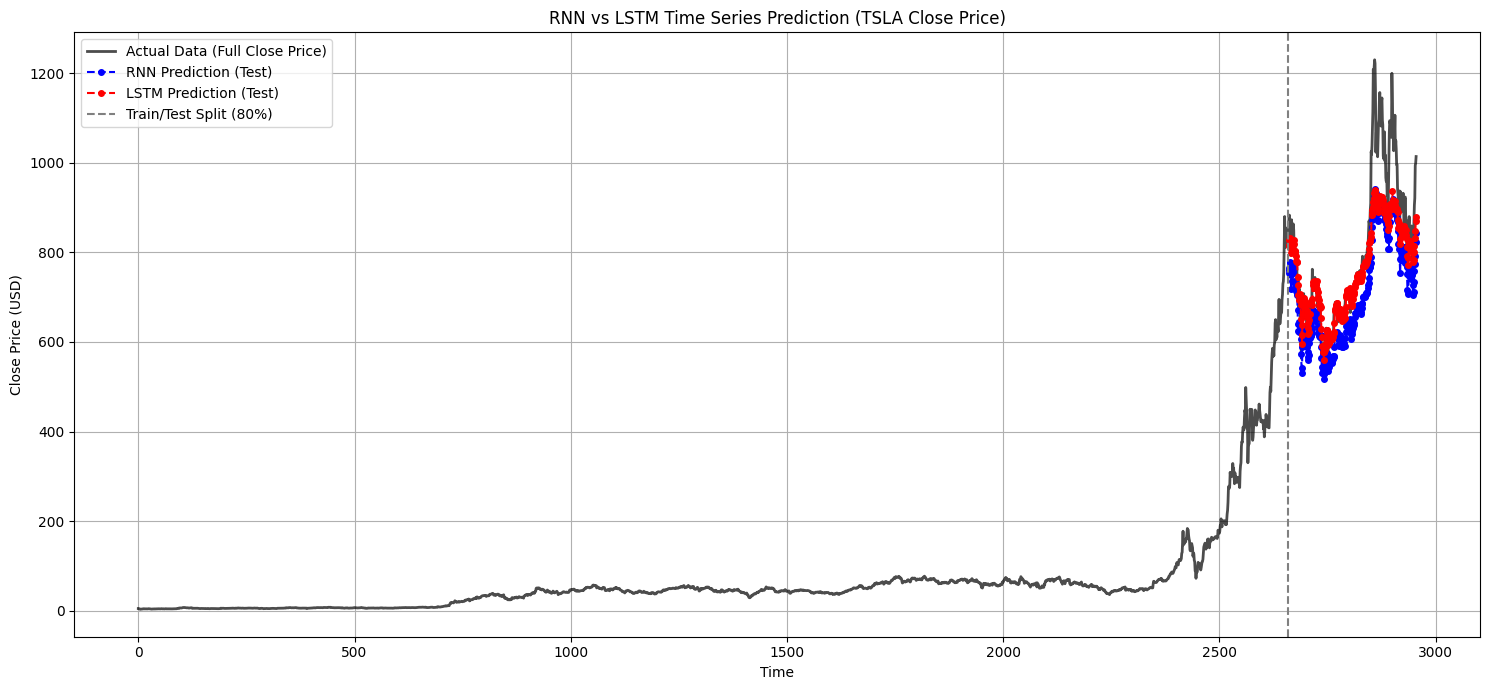

In [11]:
# -------------------------------------
# 8. 평가 및 시각화
# -------------------------------------
def get_predictions(model, loader, target_scaler): # (scaler -> target_scaler)
    model.eval()
    predictions_scaled_list = []
    actuals_scaled_list = []
    predictions_orig_list = []
    actuals_orig_list = []

    with torch.no_grad():
        for sequences, labels in loader:
            sequences, labels = sequences.to(device), labels.to(device)
            # y_pred_scaled_tensor shape: [batch_size, 1]
            y_pred_scaled_tensor = model(sequences)

            # 1. 스케일링된 값 (0-1) 저장
            y_pred_scaled = y_pred_scaled_tensor.cpu().numpy()
            y_actual_scaled = labels.cpu().numpy()
            predictions_scaled_list.append(y_pred_scaled)
            actuals_scaled_list.append(y_actual_scaled)

            # 2. 원본 스케일 값 저장 (역변환)
            y_pred_orig = target_scaler.inverse_transform(y_pred_scaled)
            y_actual_orig = target_scaler.inverse_transform(y_actual_scaled)
            predictions_orig_list.append(y_pred_orig)
            actuals_orig_list.append(y_actual_orig)

    predictions_scaled = np.array(predictions_scaled_list).flatten()
    actuals_scaled = np.array(actuals_scaled_list).flatten()
    predictions_orig = np.array(predictions_orig_list).flatten()
    actuals_orig = np.array(actuals_orig_list).flatten()

    return predictions_scaled, actuals_scaled, predictions_orig, actuals_orig

# (중요) 타겟 스케일러(scaler_target)를 전달
pred_rnn_scaled, actual_rnn_scaled, pred_rnn_orig, actual_rnn_orig = get_predictions(model_rnn, test_loader, scaler_target)
pred_lstm_scaled, actual_lstm_scaled, pred_lstm_orig, actual_lstm_orig = get_predictions(model_lstm, test_loader, scaler_target)


# 1. [필수] 원본 스케일 (USD)로 MSE/RMSE 계산 (의미 있는 성능 지표)
mse_rnn_orig = mean_squared_error(actual_rnn_orig, pred_rnn_orig)
mse_lstm_orig = mean_squared_error(actual_lstm_orig, pred_lstm_orig)
rmse_rnn_orig = np.sqrt(mse_rnn_orig)
rmse_lstm_orig = np.sqrt(mse_lstm_orig)

print("\n--- 1. Test Set Performance (Original Scale - USD) ---")
print("이것이 실제 모델 성능을 나타내는 의미있는 지표입니다 (예: RMSE=6 -> 6달러 오차).")
print(f"RNN  - MSE: {mse_rnn_orig:.2f}, RMSE: {rmse_rnn_orig:.2f}")
print(f"LSTM - MSE: {mse_lstm_orig:.2f}, RMSE: {rmse_lstm_orig:.2f}")


# 2. [참고] 역변환을 안 한 스케일링된 값 (0-1)로 MSE/RMSE 계산
print("\n--- 2. Test Set Performance (Scaled 0-1) ---")
print("이것은 0-1로 정규화된 값 기준의 오차이며, 실제 성능을 직관적으로 보여주지 않습니다.")
mse_rnn_scaled = mean_squared_error(actual_rnn_scaled, pred_rnn_scaled)
mse_lstm_scaled = mean_squared_error(actual_lstm_scaled, pred_lstm_scaled)
rmse_rnn_scaled = np.sqrt(mse_rnn_scaled)
rmse_lstm_scaled = np.sqrt(mse_lstm_scaled)
print(f"RNN  - MSE (scaled): {mse_rnn_scaled:.6f}, RMSE (scaled): {rmse_rnn_scaled:.6f}")
print(f"LSTM - MSE (scaled): {mse_lstm_scaled:.6f}, RMSE (scaled): {rmse_lstm_scaled:.6f}")


print("\n--- Test Set Predictions (Original Scale) ---")
print(f"Actuals:\n{actual_lstm_orig}")
print(f"RNN Preds:\n{pred_rnn_orig}")
print(f"LSTM Preds:\n{pred_lstm_orig}")


# 시각화 (원본 스케일 값(orig)을 사용)
plt.figure(figsize=(15, 7))
plt.title("RNN vs LSTM Time Series Prediction (TSLA Close Price)")
plt.ylabel("Close Price (USD)")
plt.xlabel("Time")
plt.grid(True)

# 1. 전체 'Close' 가격 데이터 (target_raw)
plt.plot(target_raw, 'k-', label='Actual Data (Full Close Price)', linewidth=2.0, alpha=0.7)

# 2. Test 예측 (RNN)
# 예측 시작 인덱스 계산
test_pred_indices = np.arange(len(target_raw) - test_size, len(target_raw))
plt.plot(test_pred_indices, pred_rnn_orig, 'b--o', label='RNN Prediction (Test)', markersize=4)

# 3. Test 예측 (LSTM)
plt.plot(test_pred_indices, pred_lstm_orig, 'r--o', label='LSTM Prediction (Test)', markersize=4)

# 경계선
plt.axvline(x=split_index - 1, c='gray', linestyle='--', label='Train/Test Split (80%)')

plt.legend()
plt.tight_layout()
plt.show()
